In [1]:
import argparse
from sklearn.mixture import GaussianMixture
import torch
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import easydict
from vade_MSE import AutoEncoderForPretrain, VaDE
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from munkres import Munkres
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import scipy as sp
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import multivariate_normal
import math



In [10]:
### HYPERPARAMETRS

ori_dim = 10
### dim low
N_CLASSES = 7
lat_dim = 2
n_samples = 1000
PLOT_NUM_PER_CLASS = 500
data_dim = ori_dim
batch = 100

DATASET : Basic Gaussian Model

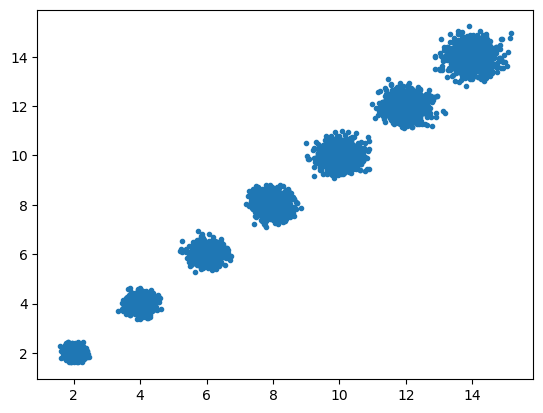

In [8]:
set_mu = []
set_cov = []

for i in range(1,N_CLASSES+1):
    mean = np.zeros(data_dim) + i*2
    for j in range(data_dim) :
        #mu_j = np.random.choice([-1, 1]) * mean[j]
        mu_j = mean[j]
        mean[j] = mu_j
    set_mu.append(mean)

# 다변량 정규분포 생성
toydata = []
for i in range(N_CLASSES):
    covariance_matrix = np.diag(np.ones(data_dim))*(i+1)/50
    mvn = multivariate_normal(mean=set_mu[i], cov=covariance_matrix)
    sample = mvn.rvs(n_samples)
    for s in sample:
        toydata.append(s)
        
datalist = np.array(toydata)
toydata = pd.DataFrame(toydata)

class CustomDataset(Dataset):
    def __init__(self, csv):
        self.inp = csv.values
        lables = []
        for i in range(N_CLASSES) :
            for j in range(n_samples):
                lables.append(i)
        lables = pd.DataFrame(lables)
        self.lable = lables.values

    def __len__(self):
        return len(self.inp) 

    def __getitem__(self,idx):
        inp = torch.FloatTensor(self.inp[idx])
        lable = torch.LongTensor(self.lable[idx])
        return inp, lable
    
dataset = CustomDataset(toydata)
data_loader = DataLoader(dataset, batch_size=500, shuffle=True)

plt.scatter(datalist[:, 0], datalist[:, 1], s = 9)

# print(data_loader)

DATASET : Spherical Model

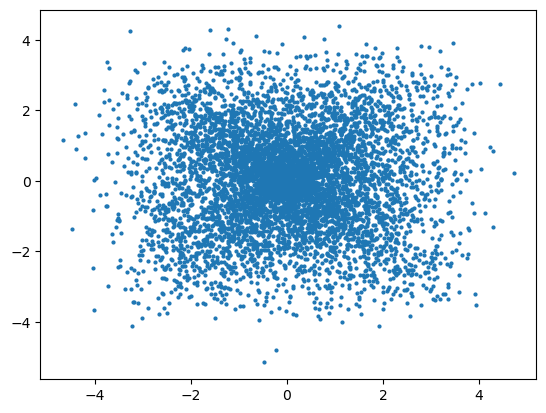

In [13]:
pt = []
for j in range (1, N_CLASSES+1) :
    for i in range (n_samples) :
        x = np.random.uniform(-j, j, ori_dim)
        x = j * x / np.linalg.norm(x)
        pt.append(x)
data = pd.DataFrame(pt)

class CustomDataset(Dataset):
    def __init__(self, csv):
        self.inp = csv.values
        lables = []
        for i in range(N_CLASSES) :
            for j in range(n_samples):
                lables.append(i)
        lables = pd.DataFrame(lables)
        self.lable = lables.values

    def __len__(self):
        return len(self.inp) 

    def __getitem__(self,idx):
        inp = torch.FloatTensor(self.inp[idx])
        lable = torch.LongTensor(self.lable[idx])
        return inp, lable
    
dataset = CustomDataset(data)
data_loader = DataLoader(dataset, batch_size=500, shuffle=True)
data = torch.Tensor(pt)
plt.scatter(data[:, 0], data[:,1], s = 4)

In [24]:
dataset = datasets.MNIST('./data', train=True, download=True,
                               transform=transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch, shuffle=True,
    num_workers=0)


PRETRAIN

In [ ]:
args = easydict.EasyDict ({
    "epochs" : 20,
    "gpu" : -1,
    "batch_size" : 100,
    "learning_rate" : 0.001,
    "out" : './vade_parameter.pth'
})

def train(model, data_loader, optimizer, device, epoch, ori_dim):
    model.train()
    total_loss = 0
    for x, _ in data_loader:
        batch_size = x.size(0)
        x = x.to(device).view(-1, ori_dim)
        recon_x = model(x)
        loss = F.mse_loss(recon_x, x, reduction='sum') / batch_size
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch {:>3}: Train Loss = {:.4f}'.format(
        epoch, total_loss / len(data_loader)))

    
if_use_cuda = torch.cuda.is_available() and args.gpu >= 0
device = torch.device('cuda:{}'.format(args.gpu) if if_use_cuda else 'cpu')

pretrain_model = AutoEncoderForPretrain(ori_dim, lat_dim).to(device)

optimizer = torch.optim.Adam(pretrain_model.parameters(),
                             lr=args.learning_rate)

for epoch in range(1, args.epochs + 1):
    train(pretrain_model, data_loader, optimizer, device, epoch, ori_dim)

with torch.no_grad():
    x = torch.cat([data[0] for data in dataset]).view(-1, ori_dim).to(device)
    z = pretrain_model.encode(x).cpu()

pretrain_model = pretrain_model.cpu()
state_dict = pretrain_model.state_dict()

gmm = GaussianMixture(n_components=N_CLASSES, covariance_type='diag')
gmm.fit(z)

model = VaDE(N_CLASSES, ori_dim, lat_dim)
model.load_state_dict(state_dict, strict=False)
model._pi.data = torch.log(torch.from_numpy(gmm.weights_)).float()
model.mu.data = torch.from_numpy(gmm.means_).float()
model.logvar.data = torch.log(torch.from_numpy(gmm.covariances_)).float()
torch.save(model.state_dict(), args.out)


In [ ]:
print(type(model), model._pi, model.mu, model.logvar)
pretrained = model
plot_points = {}
for t in range(10):
    points = torch.cat([data for data, label in dataset if label == t])
    points = points.view(-1, data_dim)[:PLOT_NUM_PER_CLASS].to(device)
    plot_points[t] = points
xs = []
ts = [] 

for t, x in plot_points.items():
    xs.append(x)
    t = torch.full((x.size(0),), t, dtype=torch.long)
    ts.append(t)
plot_points = (torch.cat(xs, dim=0), torch.cat(ts, dim=0))

xs, ts = plot_points[0].to(device), plot_points[1].numpy()
zs = model.encode(xs)[0].detach().cpu().numpy()
tsne = TSNE(n_components=2, init='pca')
zs_tsne = tsne.fit_transform(zs)
cmap = plt.get_cmap("tab10")
for d,l,p in zip(xs, ts, zs_tsne) :
    plt.scatter(p[0], p[1], color = cmap(l), s = 4)

xxx = pretrain_model(xs)
print(xxx.p)

MAINTRAING

In [19]:
from scipy import stats

args = easydict.EasyDict ({
    "epochs" : 100,
    "gpu" : -1,
    "learning_rate" : 0.0001,
    "batch_size" : 100,
    "pretrain" : None#'./vade_parameter.pth'
})

def _reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std
    return z

def loss_order(model):
    ordreg = torch.zeros(N_CLASSES-2, N_CLASSES, dtype = torch.long)
    for i in range(N_CLASSES-2) :
        ordreg[i][i], ordreg[i][i+1], ordreg[i][i+2] = 1, -2, 1
    S = np.matmul(ordreg,model.mu.detach().numpy())
    loss_order = torch.sum(S*S)
    return loss_order

def cor(model):
    m= model.mu.detach().numpy()
    r = stats.pearsonr(m[:,0], m[:,1])[0]
    return r*r

def lossfun(model, x, recon_x, mu, logvar):
    batch_size = x.size(0)
    # Compute gamma ( q(c|x) )
    z = _reparameterize(mu, logvar).unsqueeze(1)
    h = z - model.mu
    h = torch.exp(-0.5 * torch.sum((h * h / model.logvar.exp()), dim=2))
    # Same as `torch.sqrt(torch.prod(model.logvar.exp(), dim=1))`
    h = h / torch.sum(0.5 * model.logvar, dim=1).exp()
    p_z_given_c = h / (2 * math.pi)
    p_z_c = p_z_given_c * model.weights
    gamma = p_z_c / torch.sum(p_z_c, dim=1, keepdim=True)

    h = logvar.exp().unsqueeze(1) + (mu.unsqueeze(1) - model.mu).pow(2)
    h = torch.sum(model.logvar + h / model.logvar.exp(), dim=2)
    xxx = torch.sum((mu.unsqueeze(1) - model.mu).pow(2))
    loss_or = loss_order(model)
    loss = F.mse_loss(recon_x, x, reduction='sum') \
        + 0.5 * torch.sum(gamma * h) \
        - torch.sum(gamma * torch.log(model.weights + 1e-9)) \
        + torch.sum(gamma * torch.log(gamma + 1e-9)) \
        - 0.5 * torch.sum(1 + logvar) \
        # + xxx * 1000
    loss = loss / batch_size
    return loss

def train(model, data_loader, optimizer, device, epoch, data_dim):
    model.train()

    total_loss = 0
    for x, _ in data_loader:
        x = x.to(device).view(-1, data_dim)
        recon_x, mu, logvar = model(x)  
        loss = lossfun(model, x, recon_x, mu, logvar)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch%10 == 0 :    
        print('Epoch {:>3}: Train Loss = {:.4f}'.format(
    epoch, total_loss / len(data_loader)))

def test(model, data_loader, device, epoch, plot_points, data_dim):
    model.eval()

    gain = torch.zeros((N_CLASSES, N_CLASSES), dtype=torch.int, device=device)
    with torch.no_grad():
        for xs, ts in data_loader:
            xs, ts = xs.to(device).view(-1, data_dim), ts.to(device)
            ys = model.classify(xs)
            for t, y in zip(ts, ys):
                gain[t, y] += 1
        cost = (torch.max(gain) - gain).cpu().numpy()
        assign = Munkres().compute(cost)
        acc = torch.sum(gain[tuple(zip(*assign))]).float() / torch.sum(gain)
    if epoch % 10 == 0 :
        print('Accuracy = {:.4f}'.format(acc))


if_use_cuda = torch.cuda.is_available() and args.gpu >= 0
device = torch.device('cuda:{}'.format(args.gpu) if if_use_cuda else 'cpu')

# For plotting
plot_points = {}
for t in range(N_CLASSES):
    points = torch.cat([data for data, label in dataset if label == t])
    points = points.view(-1, data_dim)[:PLOT_NUM_PER_CLASS].to(device)
    plot_points[t] = points
xs = []
ts = []
for t, x in plot_points.items():
    xs.append(x)
    t = torch.full((x.size(0),), t, dtype=torch.long)
    ts.append(t)
plot_points = (torch.cat(xs, dim=0), torch.cat(ts, dim=0))

model = VaDE(N_CLASSES, ori_dim, lat_dim)
if args.pretrain:
    model.load_state_dict(torch.load(args.pretrain))
    model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
# LR decreases every 10 epochs with a decay rate of 0.9
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=10, gamma=0.6)

for epoch in range(1, args.epochs + 1):
    train(model, data_loader, optimizer, device, epoch, data_dim)
    test(model, data_loader, device, epoch, plot_points, data_dim)
    lr_scheduler.step()

xs, ts = plot_points[0].to(device), plot_points[1].numpy()
zs = model.encode(xs)[0].detach().cpu().numpy()


colors = ['red', 'orange', 'yellow', 'g', 'b', 'navy', 'purple']
mu = model.mu.detach().cpu().numpy()




Epoch  10: Train Loss = 22.0301
Accuracy = 0.1761
Epoch  20: Train Loss = 21.7411
Accuracy = 0.1976
Epoch  30: Train Loss = 21.6112
Accuracy = 0.2030
Epoch  40: Train Loss = 21.5188
Accuracy = 0.2029
Epoch  50: Train Loss = 21.4846
Accuracy = 0.1989
Epoch  60: Train Loss = 21.4536
Accuracy = 0.2019
Epoch  70: Train Loss = 21.4457
Accuracy = 0.1990
Epoch  80: Train Loss = 21.4253
Accuracy = 0.1996
Epoch  90: Train Loss = 21.4220
Accuracy = 0.1986
Epoch 100: Train Loss = 21.4177
Accuracy = 0.1960


In [7]:
ss = np.vstack([zs, mu])
tsne = TSNE(n_components=2, init='pca')
ss_tsne = tsne.fit_transform(ss)

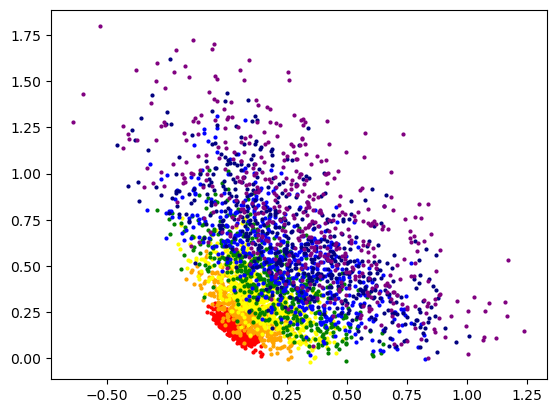

In [20]:
plt.figure(1)
cmap = plt.get_cmap("tab10")
for d,l,p in zip(xs, ts, zs) :
    plt.scatter(p[0], p[1], color = colors[l], s = 4)

